First we import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score



Next we load the data and start exploring it

In [2]:
dataframe = pd.read_csv("data.csv",index_col=0)
dataframe.head()


,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
dataframe.shape


(863, 14)

In [4]:
dataframe.columns.values.tolist()

['location',
 'country',
 'gender',
 'age',
 'vis_wuhan',
 'from_wuhan',
 'symptom1',
 'symptom2',
 'symptom3',
 'symptom4',
 'symptom5',
 'symptom6',
 'diff_sym_hos',
 'result']

In [5]:
dataframe.dtypes

location          int64
country           int64
gender            int64
age             float64
vis_wuhan         int64
from_wuhan        int64
symptom1          int64
symptom2          int64
symptom3          int64
symptom4          int64
symptom5          int64
symptom6          int64
diff_sym_hos      int64
result            int64
dtype: object

Renaming columns with difficult-to-interpret names 

In [6]:
dataframe.rename(columns = {'vis_wuhan':'visited_wuhan'}, inplace = True)
dataframe.rename(columns = {'diff_sym_hos':'days_before_symptoms'}, inplace = True)

In [7]:
dataframe.columns.to_list()

['location',
 'country',
 'gender',
 'age',
 'visited_wuhan',
 'from_wuhan',
 'symptom1',
 'symptom2',
 'symptom3',
 'symptom4',
 'symptom5',
 'symptom6',
 'days_before_symptoms',
 'result']

Checking for columns with NaN values

In [8]:
dataframe.columns[dataframe.isna().any()]

Index([], dtype='object')

Checking unique values in columns with categorical data

In [9]:
np.unique(dataframe.gender)

array([0, 1, 2])

In [10]:
np.unique(dataframe['visited_wuhan'])

array([0, 1])

In [11]:
np.unique(dataframe['from_wuhan'])

array([0, 1])

In [12]:
np.unique(dataframe['symptom6'])

array([0, 1])

Assigning independent and target values

In [13]:
X = dataframe.iloc[:,:13]  #independent columns
y = dataframe.iloc[:,-1].values.reshape(-1,1)
print(X.shape)
print(y.shape)    

(863, 13)
(863, 1)


Checking for correlation between each feature and the target to see if unneeded features are to be to dropped

In [14]:
dataframe.drop("result", axis=1).apply(lambda x: x.corr(dataframe.result))

location                0.046240
country                -0.094443
gender                 -0.061441
age                     0.515127
visited_wuhan          -0.151122
from_wuhan              0.128314
symptom1               -0.163039
symptom2               -0.103270
symptom3               -0.074982
symptom4               -0.108723
symptom5                0.020676
symptom6                0.012882
days_before_symptoms    0.219116
dtype: float64

The feature that correlates the most with the result is the "age", but since the rest of the correlations (whether positive or negative) are small and we can not consider only the age feature for creating the model, we are going to use all the features for the model creation.

Using one-hot encoding with columns that contain categorical values (the columns of "vis_wuhan" and "from_wuhan" already have values of 0 and 1 only so no need to include them)

In [15]:
X_new = pd.get_dummies(X,columns = ['location','country','symptom1','symptom2','symptom3','symptom4','symptom5','gender'])
X_new.shape

(863, 275)

In [16]:
X_new.head()

,age,visited_wuhan,from_wuhan,symptom6,days_before_symptoms,location_0,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,location_11,location_12,location_13,location_14,location_15,location_16,location_17,location_18,location_19,location_20,location_21,location_22,location_23,location_24,location_25,location_26,location_27,location_28,location_29,location_30,location_31,location_32,location_33,location_34,...,symptom3_0,symptom3_1,symptom3_2,symptom3_3,symptom3_4,symptom3_5,symptom3_6,symptom3_7,symptom3_8,symptom3_9,symptom3_10,symptom3_11,symptom3_12,symptom3_13,symptom3_14,symptom3_15,symptom3_16,symptom3_17,symptom3_18,symptom3_19,symptom4_0,symptom4_1,symptom4_2,symptom4_3,symptom4_4,symptom4_5,symptom4_6,symptom4_7,symptom4_8,symptom4_9,symptom4_10,symptom4_11,symptom4_12,symptom5_0,symptom5_1,symptom5_2,symptom5_3,gender_0,gender_1,gender_2
0,66.0,1,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,56.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,46.0,0,1,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,60.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,58.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


In [17]:
X_new.location_0.dtype

dtype('uint8')

In [18]:
type(X_new)

pandas.core.frame.DataFrame

In [19]:
type(y)

numpy.ndarray

Splitting the data into train, validation and test sets (with ratios 0.6,0.2 and 0.2 respectively)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=10,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10,shuffle=True)

In [21]:
X_train.head()

,age,visited_wuhan,from_wuhan,symptom6,days_before_symptoms,location_0,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,location_11,location_12,location_13,location_14,location_15,location_16,location_17,location_18,location_19,location_20,location_21,location_22,location_23,location_24,location_25,location_26,location_27,location_28,location_29,location_30,location_31,location_32,location_33,location_34,...,symptom3_0,symptom3_1,symptom3_2,symptom3_3,symptom3_4,symptom3_5,symptom3_6,symptom3_7,symptom3_8,symptom3_9,symptom3_10,symptom3_11,symptom3_12,symptom3_13,symptom3_14,symptom3_15,symptom3_16,symptom3_17,symptom3_18,symptom3_19,symptom4_0,symptom4_1,symptom4_2,symptom4_3,symptom4_4,symptom4_5,symptom4_6,symptom4_7,symptom4_8,symptom4_9,symptom4_10,symptom4_11,symptom4_12,symptom5_0,symptom5_1,symptom5_2,symptom5_3,gender_0,gender_1,gender_2
200,25.0,1,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
342,55.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
178,49.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
500,25.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
718,37.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


Using the validation set with different values of k to find the best accuracy score

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_predict=knn.predict(X_val)
print(accuracy_score(y_val,y_predict))

0.9479768786127167


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [23]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_predict=knn.predict(X_val)
print(accuracy_score(y_val,y_predict))

0.930635838150289


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [24]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_predict=knn.predict(X_val)
print(accuracy_score(y_val,y_predict))

0.9421965317919075


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Choosing k=3 and using the test set 

In [25]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_predict_test=knn.predict(X_test)
print(accuracy_score(y_test,y_predict_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9248554913294798


Scaling columns with numeric data (age and days before symptoms) so that the values lie between 0 and 1, then testing whether the accuracy would change or not for the same value of k=3

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(X_new)
X_new_scaled.shape

(863, 275)

In [27]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_new_scaled, y, test_size=0.2, random_state=10,shuffle=True)

X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_train_scaled, y_train_scaled, test_size=0.25, random_state=10,shuffle=True)

X_train_scaled.shape

(517, 275)

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train_scaled)
y_predict_test=knn.predict(X_test_scaled)
print(accuracy_score(y_test,y_predict_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9075144508670521


Reverting the data to how it was before scaling since the accuracy dropped by 2% 

Now using k-fold cross validation for choosing the best k

Using the convention that k should be less than the square root of n, where n is the number of samples

In [29]:
k_range = range(1, int(np.sqrt(X_new.shape[0])))
k_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors= k)
  scores = cross_val_score(knn, X_new, np.ravel(y) , cv = 10, scoring= 'accuracy')
  k_scores.append(scores.mean())

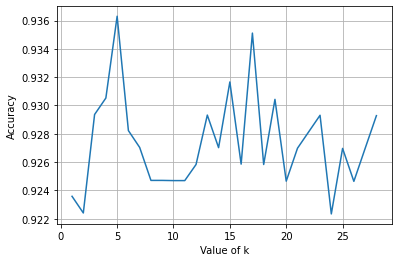

In [30]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.grid()

In [31]:
sorted(zip(k_scores, k_range), reverse=True)[:2]

[(0.9363004544239507, 5), (0.9351109329056403, 17)]

We pick k as 17 since a small value of k would cause overfitting

In [32]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
y_predict_test=knn.predict(X_test)
print("Accuracy: ", accuracy_score(y_test,y_predict_test))
print("Precision: ", precision_score(y_test,y_predict_test))
print("Recall: ", recall_score(y_test,y_predict_test))
print("f1score: ", f1_score(y_test,y_predict_test))

Accuracy:  0.9190751445086706
Precision:  0.9166666666666666
Recall:  0.4583333333333333
f1score:  0.611111111111111


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


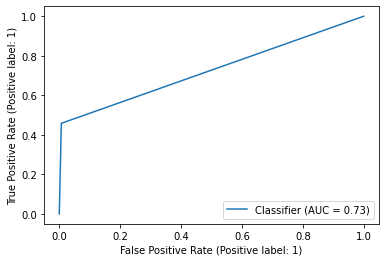

AUC: 0.72581096196868


In [33]:
RocCurveDisplay.from_predictions(y_test, y_predict_test)
plt.show()
auc=roc_auc_score(y_test, y_predict_test)
print("AUC:", auc)

**Implementing K-NN algorithm from scratch**

In [34]:
from scipy.stats import mode
 
def eucledian_dist(x1,x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance
 

def knn_alg(X_train, y_train , X_test, k):
    prediction_labels=[]
    for x in X_test: 

        distances = []         
        for i in range(len(X_train)): 
            distance = eucledian_dist(x, X_train[i,:]) 
            distances.append(distance) 

        distances = np.array(distances) 
        k_distances = np.argsort(distances)[:k] 
        labels = y_train[k_distances]
        label = mode(labels).mode[0]
        prediction_labels.append(label)
 
    return prediction_labels

Using our implemented algorithm on the training and test sets with the optimal value of k that we got through cross validation

In [35]:
y_pred = knn_alg(X_train.values,y_train,X_test.values, 17)
 
accuracy_score(y_test, y_pred)


0.9190751445086706

The same accuracy score was achieved as the one we got from sklearn's KNN (91.9%)

**Now moving to the Logistic Regression** 

In [36]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import linear_model, preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


y_predict=[]
logreg = linear_model.LogisticRegression()

Using GridSearch to find the best tuning for the hyperparameters (therefore no need for the validation set)

In [37]:
param_grid = [    
    {'penalty' : ['l1','l2','none'],
    'C' : [0.1,1,10,100],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    }
]
clf = GridSearchCV(logreg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [38]:
clf.fit(X_train,y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=True)

Some combinations of parameters do not fit together but the GridSearch was able to find the best combination of hyperparameters nevertheless

In [39]:
clf.best_estimator_

LogisticRegression(C=10, solver='newton-cg')

In [40]:
ypred = clf.predict(X_test)
accuracy_score(y_test,ypred)

0.976878612716763

In [41]:
print ('Accuracy',metrics.accuracy_score(y_test,ypred))
print ('F1 score:', f1_score(y_test,ypred))
print ('Recall:', recall_score(y_test,ypred))
print ('Precision:', precision_score(y_test,ypred))
print ('\n clasification report:\n', classification_report(y_test,ypred))
print ('\n confussion matrix:\n',confusion_matrix(y_test,ypred))

Accuracy 0.976878612716763
F1 score: 0.9166666666666666
Recall: 0.9166666666666666
Precision: 0.9166666666666666

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.92      0.92      0.92        24

    accuracy                           0.98       173
   macro avg       0.95      0.95      0.95       173
weighted avg       0.98      0.98      0.98       173


 confussion matrix:
 [[147   2]
 [  2  22]]


Plotting the precision Vs recall graph

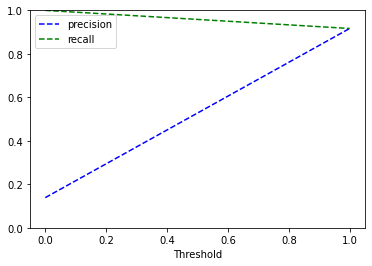

In [42]:
from sklearn.metrics import precision_recall_curve
prec, rec, tre = precision_recall_curve(y_test, ypred, )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

0.9516219239373601


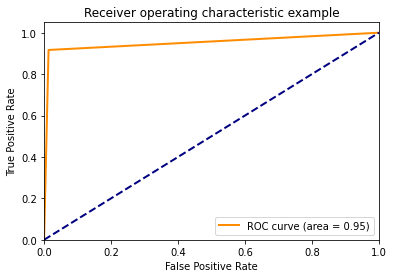

In [43]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred, pos_label=1)
roc_auc = roc_auc_score(y_test,ypred)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

**Now moving to the SVM**

For the SVM, scaled data has to be used so we use the data generated from the MinMax Scaler

In [44]:
from sklearn import svm
modelSVM = svm.SVC()

In [45]:
param_grid = [    
    {
    'C' : [0.1,1,10,100],
     'gamma' : [1,0.1,0.01,0.001],
     'kernel':['linear', 'poly', 'rbf'],
     'degree': [2,3,4]

    }
]

In [46]:
clf = GridSearchCV(modelSVM, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [47]:
clf.fit(X_train_scaled, y_train_scaled.ravel())


Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [1, 0.1, 0.01, 0.001],
                          'kernel': ['linear', 'poly', 'rbf']}],
             verbose=True)

In [48]:
clf.best_estimator_

SVC(C=100, degree=2, gamma=1, kernel='linear')

In [49]:
ypred = clf.predict(X_test_scaled)

In [50]:
print ('Accuracy',metrics.accuracy_score(y_test_scaled,ypred))
print ('F1 score:', f1_score(y_test_scaled,ypred))
print ('Recall:', recall_score(y_test_scaled,ypred))
print ('Precision:', precision_score(y_test_scaled,ypred))

Accuracy 0.9826589595375722
F1 score: 0.9387755102040817
Recall: 0.9583333333333334
Precision: 0.92


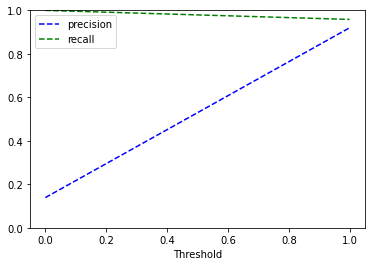

In [51]:
prec, rec, tre = precision_recall_curve(y_test, ypred, )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [52]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred, pos_label=1)
roc_auc = roc_auc_score(y_test,ypred)
print(roc_auc)

0.9724552572706936


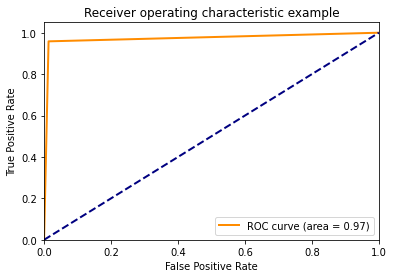

In [53]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

**Decision tree**

In [54]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn import tree
criterion = ['gini', 'entropy']
max_depth = [2,4,6,7,8,10,12]
dec_tree = tree.DecisionTreeClassifier()
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth)
pipe = Pipeline(steps=[('dec_tree', dec_tree)])

In [55]:
clf_GS = GridSearchCV(pipe, parameters, cv = 5, verbose=True, n_jobs=-1)
clf_GS.fit(X_train, y_train)
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Criterion: entropy
Best max_depth: 12

DecisionTreeClassifier(criterion='entropy', max_depth=12)


In [56]:
Model_dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
Model_dt = Model_dt.fit(X_train, y_train_scaled.ravel())
y_pred = Model_dt.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.953757225433526


In [68]:
print ('Accuracy',metrics.accuracy_score(y_test,y_pred))
print ('F1 score:', f1_score(y_test,y_pred))
print ('Recall:', recall_score(y_test,y_pred))
print ('Precision:', precision_score(y_test,y_pred))

Accuracy 0.953757225433526
F1 score: 0.8260869565217391
Recall: 0.7916666666666666
Precision: 0.8636363636363636


In [58]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test,y_pred)
print(roc_auc)

0.8857662192393735


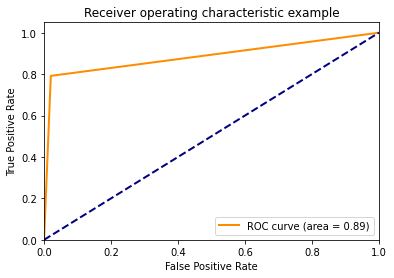

In [59]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

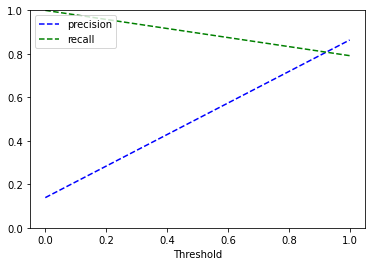

In [60]:
prec, rec, tre = precision_recall_curve(y_test, y_pred, )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

**Naive Bayes**

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,    
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train.ravel())

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.02848035868435802}

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledX = scaler.fit_transform(X_train)
scaledTest = scaler.fit_transform(X_test)
nb_classifier = GaussianNB(var_smoothing=0.02848035868435802)
nb_classifier = nb_classifier.fit(scaledX, np.ravel(y_train))
y_predscaled = nb_classifier.predict(scaledTest)

bnb = BernoulliNB()
bnb = bnb.fit(scaledX,np.ravel(y_train))
y_predbnb = bnb.predict(scaledTest)

In [63]:
print ('Accuracy',metrics.accuracy_score(y_test,y_predbnb))
print ('F1 score:', f1_score(y_test,y_predbnb))
print ('Recall:', recall_score(y_test,y_predbnb))
print ('Precision:', precision_score(y_test,y_predbnb))


Accuracy 0.8323699421965318
F1 score: 0.32558139534883723
Recall: 0.2916666666666667
Precision: 0.3684210526315789


In [64]:
print ('Accuracy',metrics.accuracy_score(y_test,y_predscaled))
print ('F1 score:', f1_score(y_test,y_predscaled))
print ('Recall:', recall_score(y_test,y_predscaled))
print ('Precision:', precision_score(y_test,y_predscaled))

Accuracy 0.5260115606936416
F1 score: 0.33870967741935487
Recall: 0.875
Precision: 0.21


In [65]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predscaled, pos_label=1)
roc_auc = roc_auc_score(y_test,y_predscaled)
print(roc_auc)

0.6723993288590604


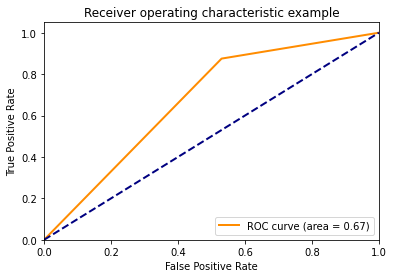

In [66]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

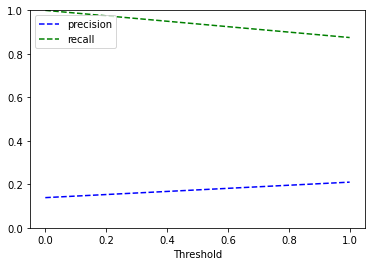

In [67]:
prec, rec, tre = precision_recall_curve(y_test, y_predscaled, )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()